### 환자의 정보를 바탕으로  

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import chardet
import warnings
from mlxtend.plotting import plot_decision_regions
warnings.filterwarnings('ignore', message= ".*deprecated.*", category = FutureWarning)
warnings.filterwarnings('ignore', category = FutureWarning)


In [6]:
with open('/kaggle/input/pima-indians-diabetes-database/diabetes.csv', 'rb') as f:
    raw_data = f.read(10000)

result = chardet.detect(raw_data)
print(result['encoding'], result['confidence'])

ascii 1.0


In [39]:
diab_df = pd.read_csv('/kaggle/input/pima-indians-diabetes-database/diabetes.csv', encoding = 'utf-8')
diab_df.sample(10)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
73,4,129,86,20,270,35.1,0.231,23,0
344,8,95,72,0,0,36.8,0.485,57,0
162,0,114,80,34,285,44.2,0.167,27,0
206,8,196,76,29,280,37.5,0.605,57,1
367,0,101,64,17,0,21.0,0.252,21,0
710,3,158,64,13,387,31.2,0.295,24,0
260,3,191,68,15,130,30.9,0.299,34,0
167,4,120,68,0,0,29.6,0.709,34,0
482,4,85,58,22,49,27.8,0.306,28,0
198,4,109,64,44,99,34.8,0.905,26,1


In [18]:
diab_df[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']] = \
diab_df[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']].replace(0, np.NaN)

print(diab_df.isnull().sum())

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64


<ipython-input-36-5024224a49c6>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


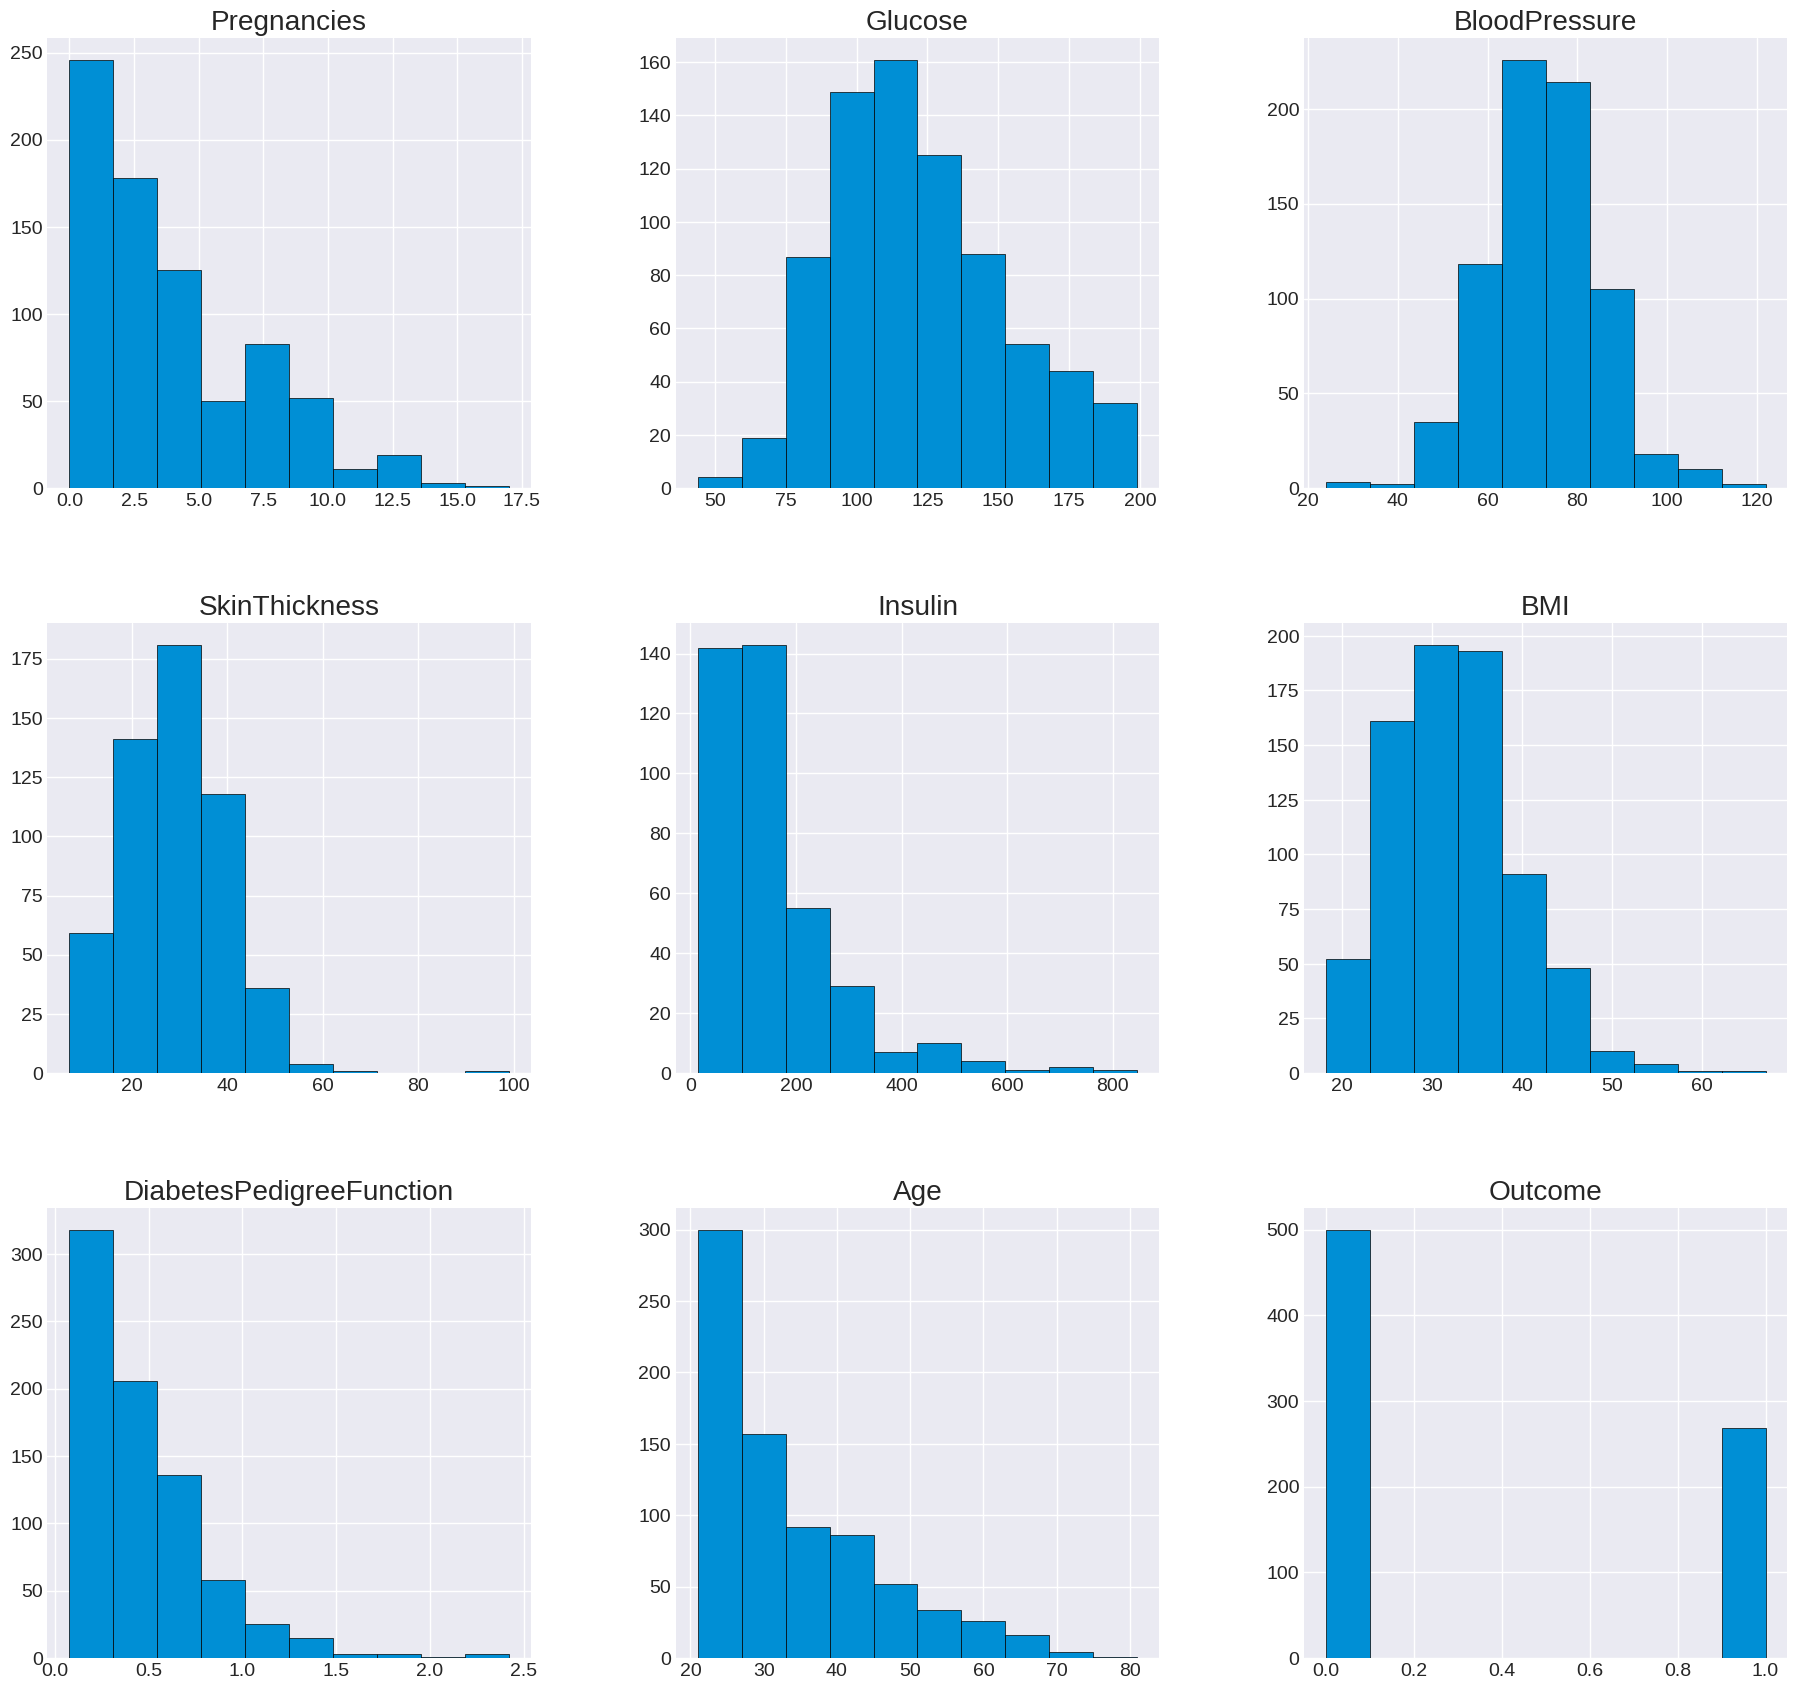

In [36]:
plt.style.use('seaborn-darkgrid')
diab_hist = diab_df.hist(figsize= (20,20))
for row in diab_hist:
    for ax in row:
        for patch in ax.patches:
            patch.set_edgecolor('black')



plt.show()

#### 결측값 대체하기 


In [ ]:
# 방법 1: 단순 결측값 대체 - 평균 혹은 중앙값 사용

diab_df['Glucose'].fillna(diab_df['Glucose'].mean(), inplace = True)
diab_df['BloodPressure'].fillna(diab_df['BloodPressure'].mean(), inplace = True)
diab_df['SkinThickness'].fillna(diab_df['SkinThickness'].median(), inplace = True)
diab_df['Insulin'].fillna(diab_df['Insulin'].median(), inplace = True)
diab_df['BMI'].fillna(diab_df['BMI'].median(), inplace = True)

In [30]:
# 방법 2: KNN 기법 사용

from sklearn.impute import KNNImputer

knn_imputer = KNNImputer(n_neighbors = 5)
diab_imputed = pd.DataFrame(knn_imputer.fit_transform(diab_df), columns = diab_df.columns)
diab_imputed.isna().sum()  # 결측값이 모두 채워졌는지 확인

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [34]:
# 방법 3: Iterative Imputing 기법 사용

from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

iter_imputer = IterativeImputer(estimator = RandomForestRegressor(n_estimators = 10), random_state = 42)

diab_imputed = pd.DataFrame(iter_imputer.fit_transform(diab_df), columns = diab_df.columns)

diab_imputed.isna().sum()


/usr/local/lib/python3.10/dist-packages/sklearn/impute/_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

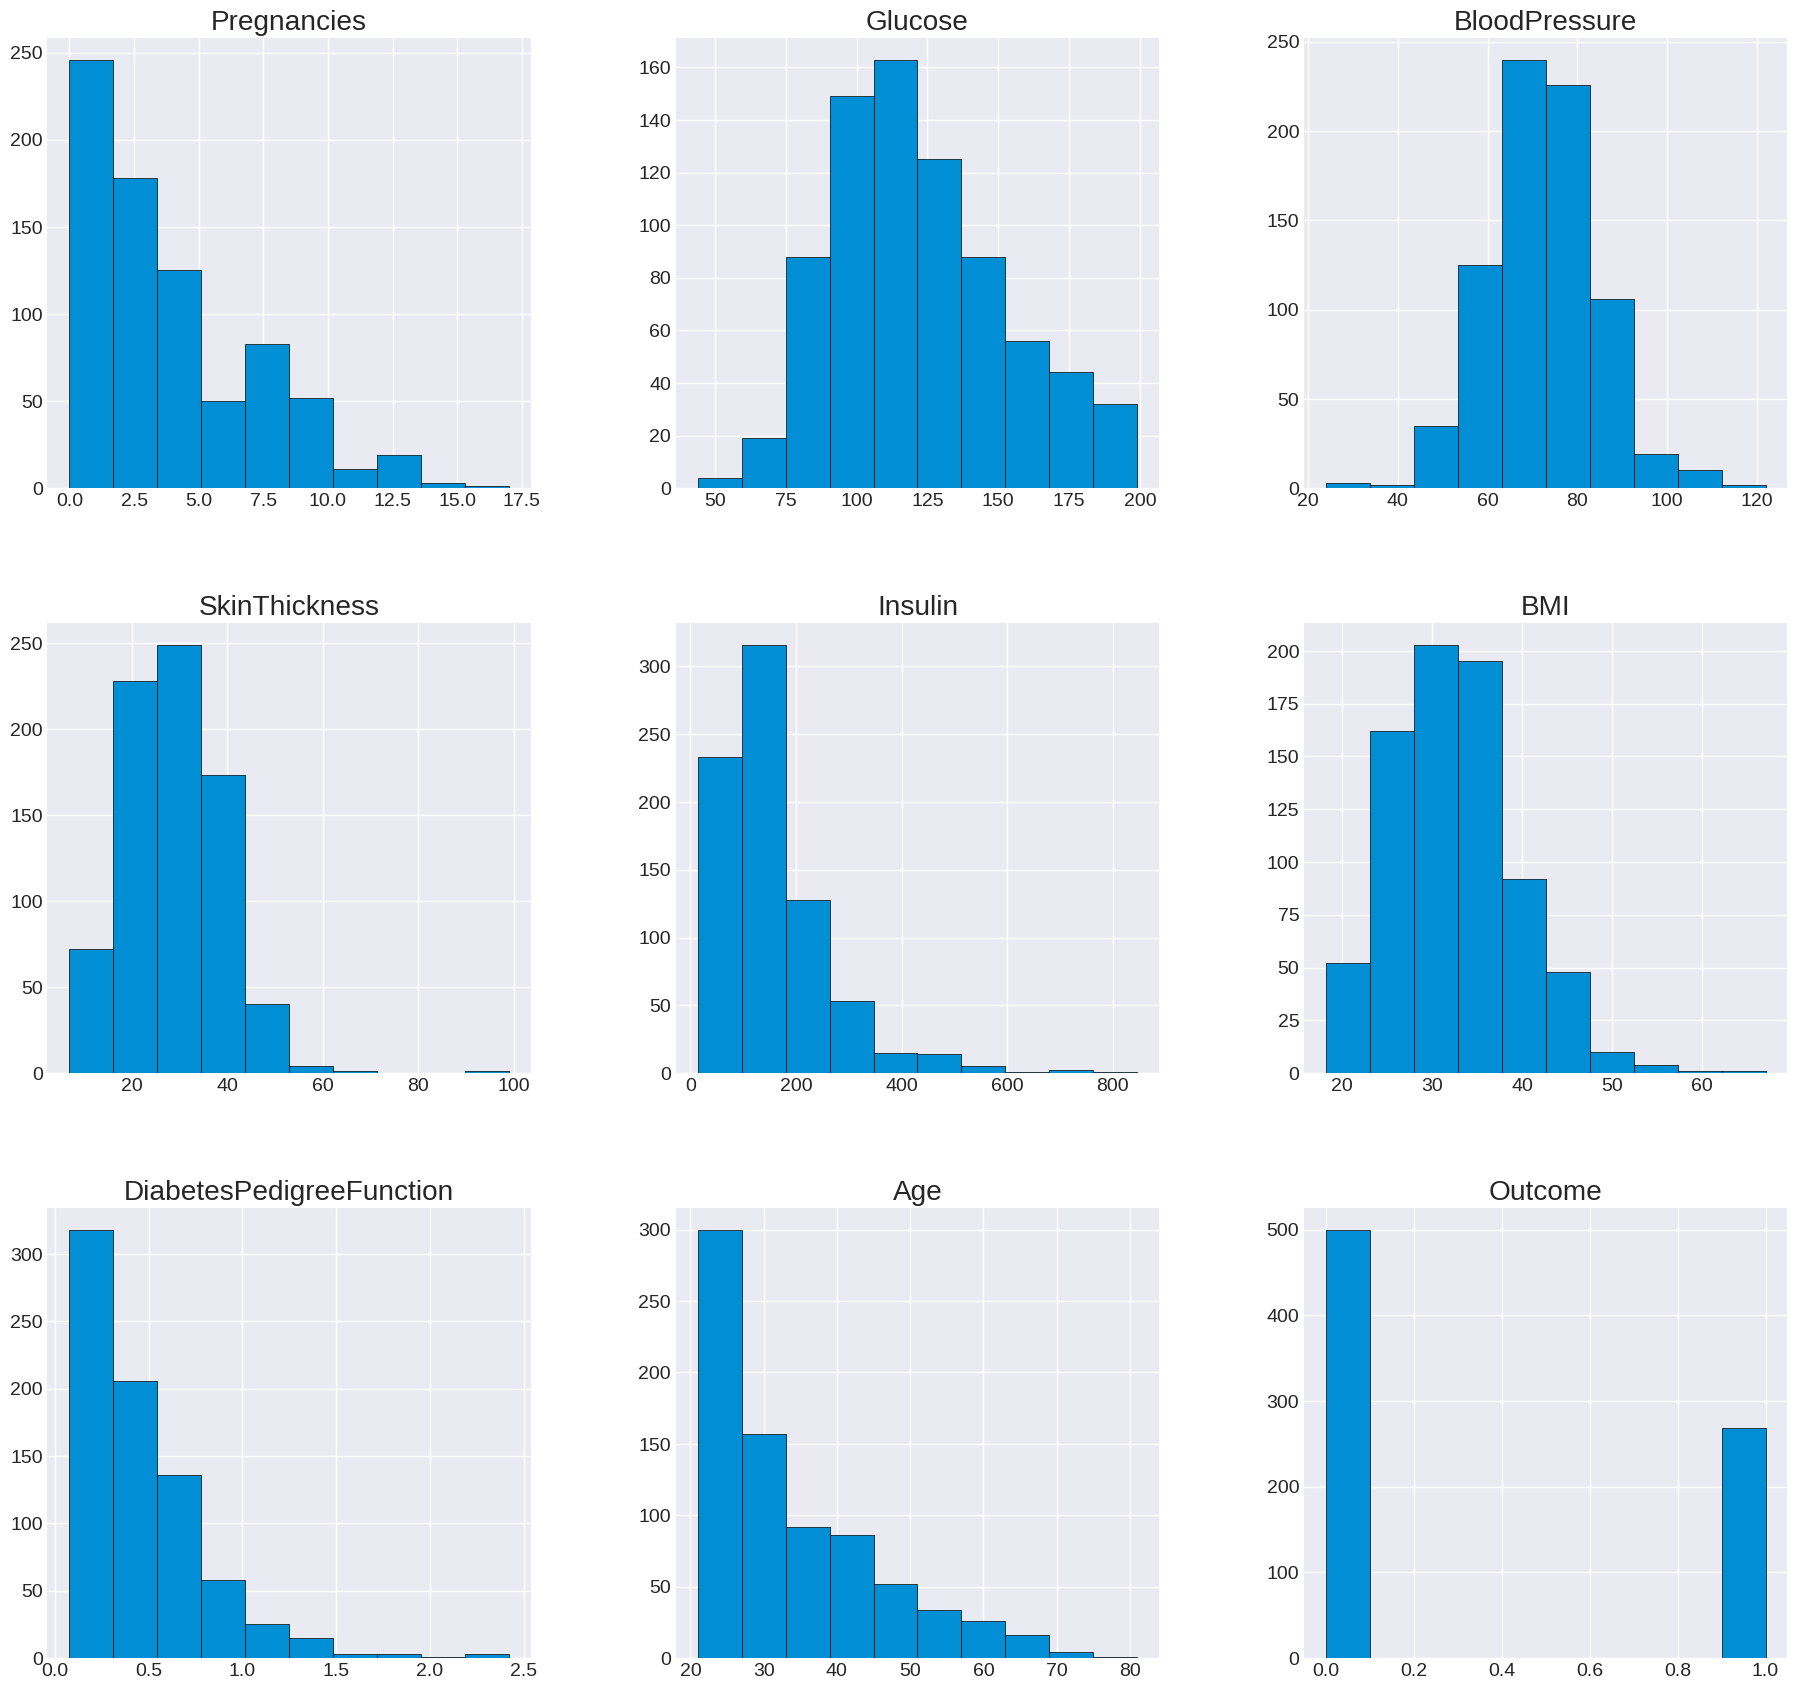

In [37]:
subplots = diab_imputed.hist(figsize = (20, 20))
for row in subplots:
    for ax in row:
        for patch in ax.patches:
            patch.set_edgecolor('black')

plt.show()

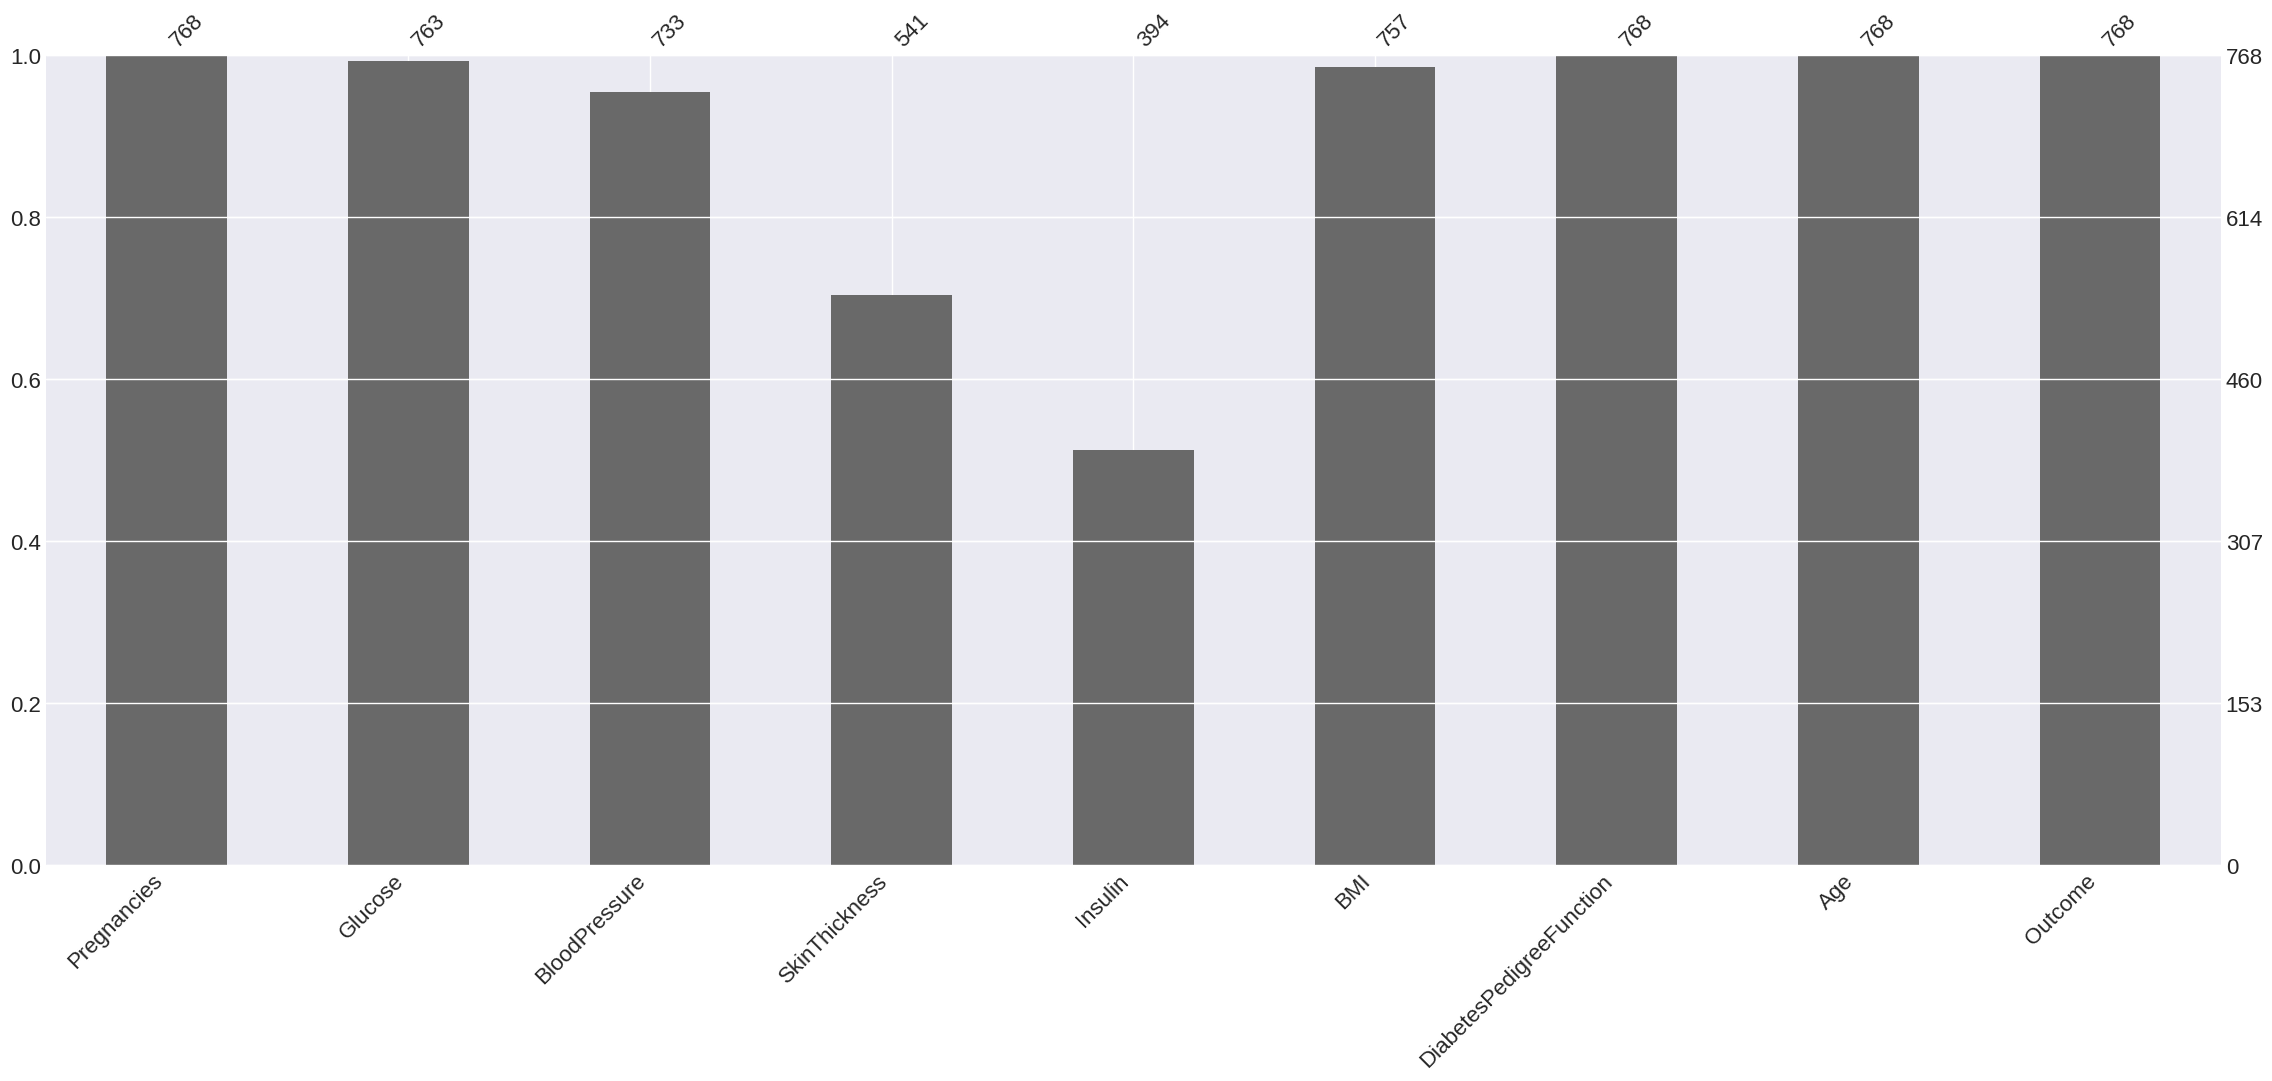

In [38]:
import missingno as msno

p = msno.bar(diab_df)


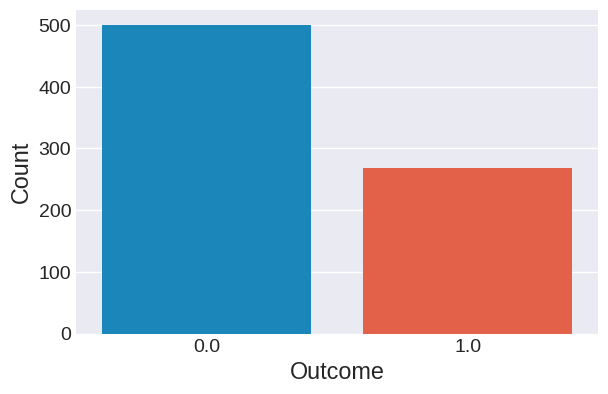

In [41]:
plt.figure(figsize = (6,4))
sns.countplot(x = diab_imputed.Outcome, data = diab_imputed)
plt.xlabel('Outcome')
plt.ylabel('Count')
plt.show()

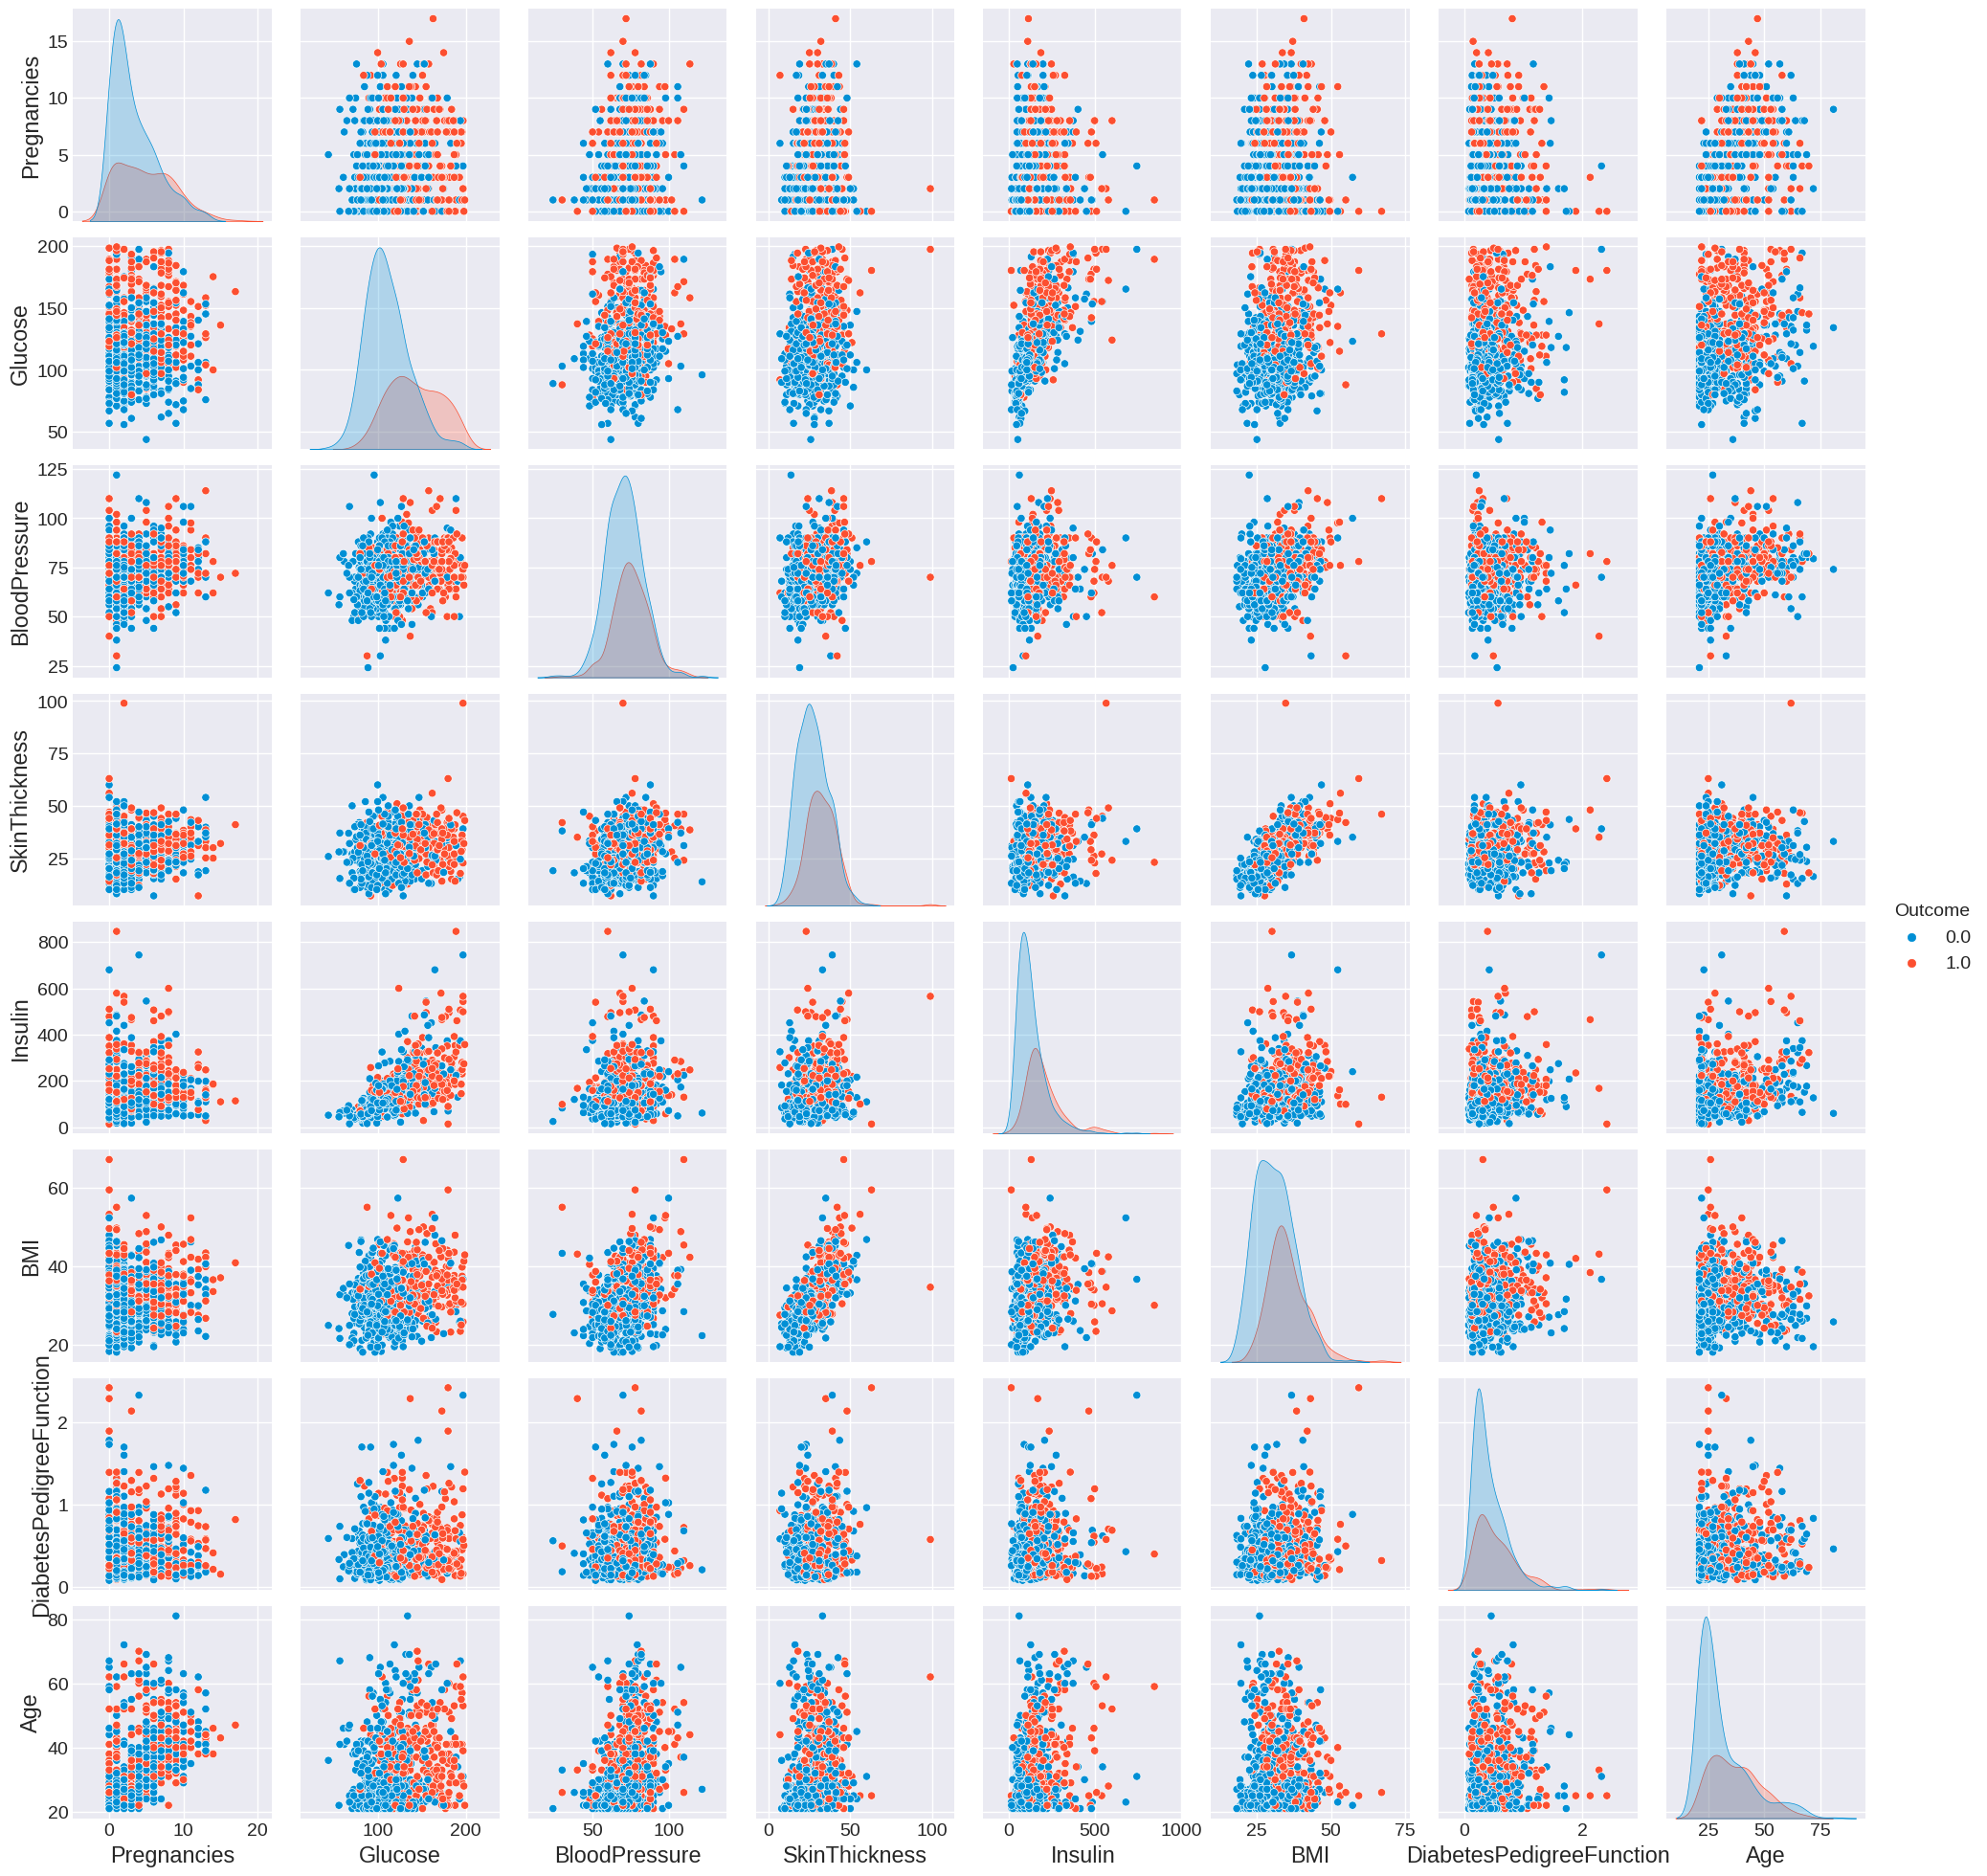

In [47]:
p = sns.pairplot(data = diab_imputed, hue = 'Outcome')

당뇨환자들의 글루코스수치가 일반적으로 좀 더 높으며 나머지 수치들은 그렇게 큰 차이가 느껴지지 않는다.
또한 BMI와 skinthickness의 양의 상관관계성이 상대적으로 있는 편이다.
<br>
이제 상관관계성을 히트맵으로 수치화해보자

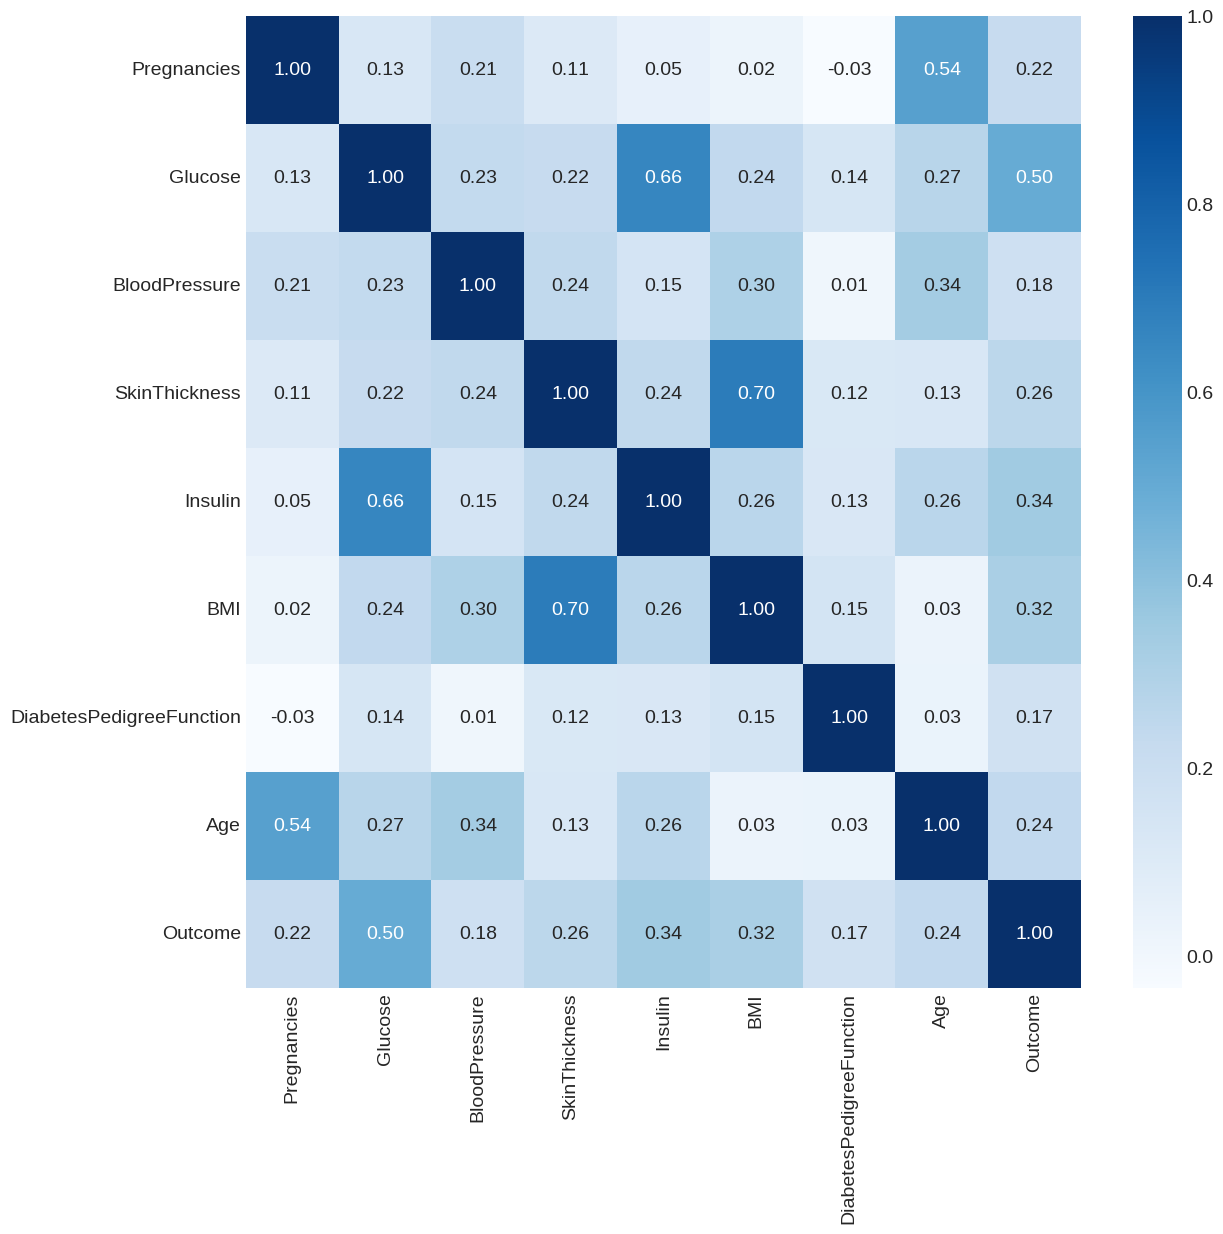

In [54]:
plt.figure(figsize = (12, 12))
diab_corr = diab_imputed.corr()
sns.heatmap(data = diab_corr, annot =True, fmt = '.2f', cmap = 'Blues')
plt.show()

수치적으로 보면 상관성이 더 뚜렷하게 보인다. Age와 Preganacies, Glucose와 Outcome, BMI와 SkinThickness 등. 글루코스 다음으론 인슐린과 Outcome의 상관계수가 높다. 또한, 대부분의 변수는 양의 상관계수를 지닌다

In [56]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


ss_scaler = StandardScaler()

X_columns = diab_imputed.columns
X_columns = [col  for col in X_columns if not col == 'Outcome']

X = pd.DataFrame(ss_scaler.fit_transform(diab_imputed.drop(['Outcome'], axis = 1),),
                 columns = X_columns)
y = diab_imputed['Outcome']

X_train,X_test,y_train,y_test = train_test_split(X, y, test_size= 0.2, random_state=42, stratify = y)


In [66]:
from sklearn.neighbors import KNeighborsClassifier

test_scores = []
train_scores = []

for i in range(1,15):
    knn = KNeighborsClassifier(n_neighbors = i)
    knn.fit(X_train, y_train)
    train_scores.append(knn.score(X_train, y_train))
    test_scores.append(knn.score(X_test, y_test))

In [70]:
max_train_score = max(train_scores)
train_scores_idx = [i  for i, v in enumerate(train_scores) if v == max_train_score]
print('Max train score {:.2f} % and k = {}'.format(
       max_train_score*100, list(map(lambda x: x+1, train_scores_idx))))


max_test_score = max(test_scores)
test_scores_ind = [i for i, v in enumerate(test_scores) if v == max_test_score]
print('Max test score {:.2f} % and k = {}'.format(
       max_test_score*100, list(map(lambda x: x+1, test_scores_ind))))

Max train score 100.00 % and k = [1]
Max test score 76.62 % and k = [8]


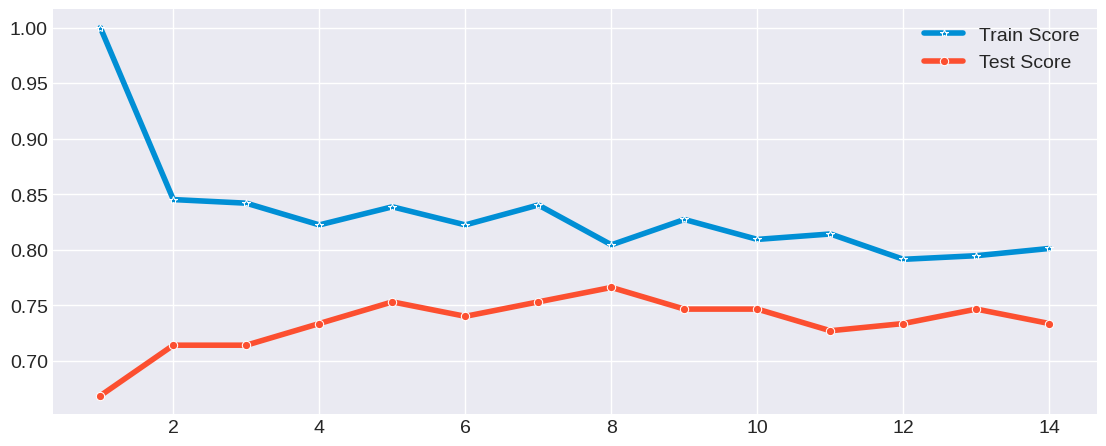

In [71]:
plt.figure(figsize=(12,5))
sns.lineplot(x = range(1, 15),  y= train_scores, marker = '*', label = 'Train Score' )
sns.lineplot(x = range(1, 15), y = test_scores, marker = 'o', label = 'Test Score')
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


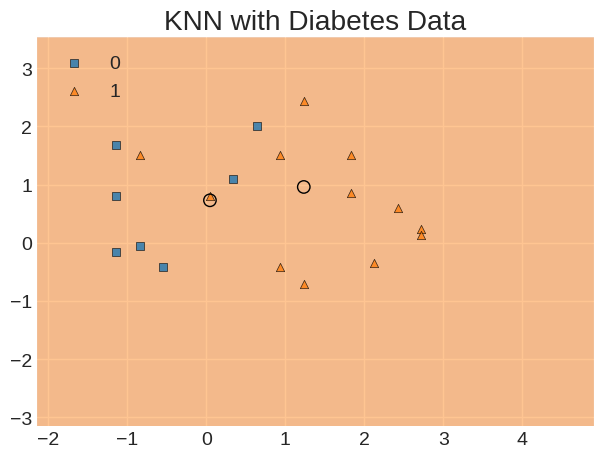

In [76]:
value = 20000
width = 20000

plot_decision_regions(X_train.values, y_train.values.astype(int), clf = knn, legend = 2,
                      filler_feature_values={2: value, 3: value, 4: value, 5: value, 6: value, 7: value},
                      filler_feature_ranges={2: width, 3: width, 4: width, 5: width, 6: width, 7: width},
                     X_highlight = X_test.values)



plt.title('KNN with Diabetes Data')
plt.show()

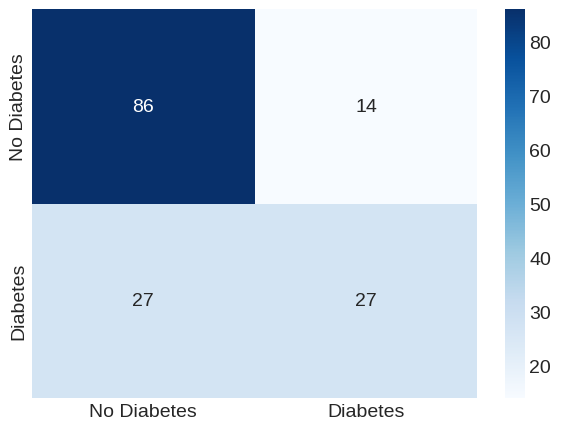

In [81]:
from sklearn.metrics import confusion_matrix

y_pred = knn.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot = True, fmt = 'd', cmap ='Blues', xticklabels = ['No Diabetes', 'Diabetes'],
           yticklabels = ['No Diabetes', 'Diabetes'])
plt.show()

In [84]:
pd.crosstab(y_test, y_pred, rownames = ['Outcome'], colnames = ['Predicted'])



Predicted,0.0,1.0
Outcome,,
0.0,86,14
1.0,27,27


In [87]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

         0.0       0.76      0.86      0.81       100
         1.0       0.66      0.50      0.57        54

    accuracy                           0.73       154
   macro avg       0.71      0.68      0.69       154
weighted avg       0.73      0.73      0.72       154



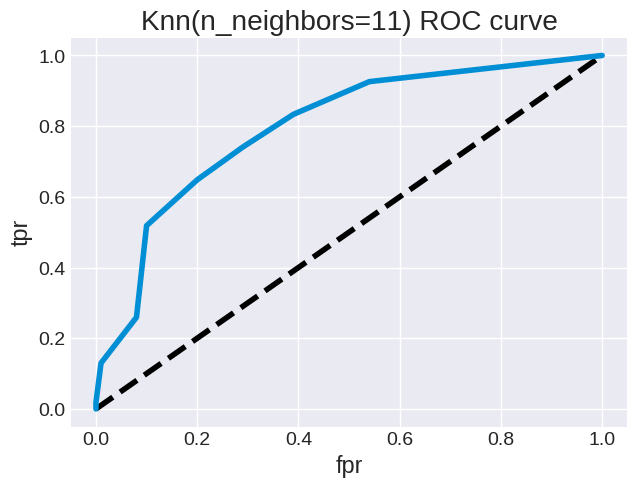

ROC_AUC Score: 0.80


In [95]:
from sklearn.metrics import roc_curve


knn = KNeighborsClassifier(n_neighbors = 8)
knn.fit(X_train, y_train)
y_pred_proba = knn.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot([0, 1], [0, 1], 'k--'  )
plt.plot(fpr, tpr, label = 'knn')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('Knn(n_neighbors=11) ROC curve')
plt.show()

from sklearn.metrics import roc_auc_score
print(f'ROC_AUC Score: {roc_auc_score(y_test, y_pred_proba):.2f}')

In [96]:
from sklearn.model_selection import GridSearchCV

param_grid = {'n_neighbors' : np.arange(1, 25)}
knn =KNeighborsClassifier()
knn_cv = GridSearchCV(estimator = knn, param_grid = param_grid, cv = 5)
knn_cv.fit(X, y)
knn_cv.fit(X,y)

print("Best Score:" + str(knn_cv.best_score_))
print("Best Parameters: " + str(knn_cv.best_params_))

Best Score:0.7813173754350224
Best Parameters: {'n_neighbors': 19}
